In [1]:
import matplotlib.pylab as plt
import matplotlib
# Matplotlib의 폰트를 'Times New Roman'으로 설정
matplotlib.rcParams['font.family'] = 'Times New Roman'
import shap
import pandas as pd
import numpy as np
import pickle
plt.rcParams['font.weight'] = 'bold'  # 모든 텍스트 요소에 대해 굵은 글씨 적용
plt.rcParams['axes.labelweight'] = 'bold'  # 축 라벨에 대해 굵은 글씨 적용

### Partial dependence plot (reference interval)

In [2]:
def model_proba(x):
    return model.predict_proba(x)[:,1]
def model_relative_proba(x):
    return model.predict_proba(x)[:,1]/expected_proba
def model_logodds(x):
    return model.predict(x, output_margin=True)
def model_odds(x):
    return np.exp(model.predict(x, output_margin=True))
def logodds_proba(x):
    return np.exp(x)/(1+np.exp(x))
def proba_logodds(x):
    return np.log(x/(1-x))
def odds_proba(x):
    return x/(1+x)
def logodds_odds(x):
    return np.exp(x)
def odds_logodds(x):
    return np.log(x)

In [3]:
# RI 정보가 저장된 Excel 파일 경로
ri_excel_path = '/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/RI.xlsx'

# Excel 파일로부터 RI 정보를 불러옵니다. 필요한 경우 sheet_name 파라미터를 조정하세요.
ri_df = pd.read_excel(ri_excel_path, sheet_name='Sheet1')

# RI 정보를 딕셔너리 형태로 변환합니다.
# 이 예제에서는 각 행이 하나의 feature를 나타내며, 'Type_Short_Name', 'RI_all' 등의 컬럼을 가정합니다.
RI_dict = ri_df.set_index('Type_Short_Name')['RI_all'].to_dict()

In [23]:
print(RI_dict)

{'WBC, Low': '4-10', 'Neutrophil count, Low': '1.9-8.0', 'RBC': '4.3-5.3', 'Hb': '13-17', 'RDW': '11.5-14.5', 'PLT, High': '150-450', 'MPV': '7.4-12.1', 'PT': '11.5-14.9', 'aPTT': '28.4-44.7', 'Albumin': '3.5-5.2', 'ALP': '40-150', 'AST': '5-34', 'ALT': '0-55', 'BUN': '8.9-20.6', 'Cr': '0.72-1.25', 'total calcium, High': '8.4-10.2', 'Total Cheloesterol': '0-200', 'GGT': '12-64', 'Direct  bilirubin': '0.0-0.5', 'Total bilirubin': '0.2-1.2', 'LD': '125-220', 'Na, Low': '136-145', 'K, Low': '3.5-5.1', 'cl, Low': '98-107', 'uric acid': '2.9-7.3', 'tCO2, High': '24-31', 'protein': '6.4-8.3', 'CRP': '0-5.0'}


In [4]:
model_name = 'thesis 2'
feature = 'uric acid'

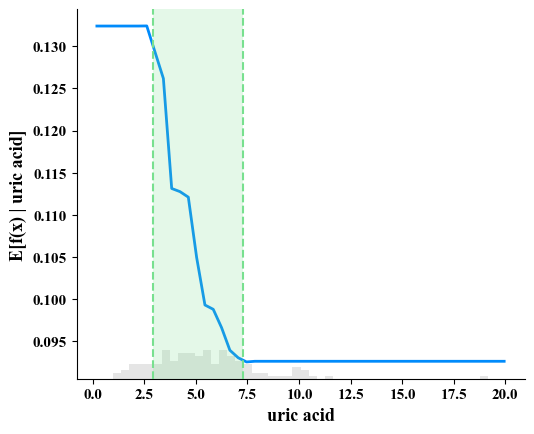

In [5]:
# Correctly extract lower and upper bounds
bounds = RI_dict[feature].split('-')
lower_bound = float(bounds[0])
upper_bound = float(bounds[1])

# Load the model
model = pickle.load(open('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/model.pickle.dat', "rb"))

# Load the data
data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')[model.get_booster().feature_names]

display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/feature_list_Display_name thesis 2.xlsx')
display_col = []
for col in data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(data.columns, display_col))

# Assuming model_proba is a function you have defined for predicting probabilities
expected_proba = model_proba(data).mean()

# Assuming shap.partial_dependence_plot is correctly referenced for plotting
# Note: The function call to shap.partial_dependence_plot might need adjustments based on your actual SHAP utility function or method
shap.partial_dependence_plot(
    feature, model_proba, data, model_expected_value=False, npoints=50, 
    feature_expected_value=False, show=False, ice=False
)
plt.subplots_adjust(left=0.2, right=0.9)  # left와 right 값을 조정해보세요
plt.axvline(x=lower_bound, color='#78e08f', linestyle='--')
plt.axvline(x=upper_bound, color='#78e08f', linestyle='--')
plt.axvspan(lower_bound, upper_bound, color='#78e08f', alpha=0.2, lw=0)
# 현재 그림을 TIFF 파일로 저장
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/RI PDP plot - '+ feature +'.tiff', format='tiff', dpi=300)
plt.show()

In [ ]:
# 현재 그림을 TIFF 파일로 저장
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/RI PDP plot.tiff', format='tiff', dpi=300)

### model comparison plot

In [11]:
def Gabe_plot_part(shap_values_A, cols_A, shap_values_B, cols_B, fea_num, days_14, days_30):
    fig = plt.figure(figsize=(4, 8))
    ax1 = fig.add_subplot(111)
    
    cols_sorted_A = cols_A[np.argsort(-np.sum(np.abs(shap_values_A), axis=0))]
    cols_sorted_B = cols_B[np.argsort(-np.sum(np.abs(shap_values_B), axis=0))]
    
    cols_sorted_A = list(cols_sorted_A[0:fea_num][::-1])
    cols_sorted_B = list(cols_sorted_B[0:fea_num][::-1])
    print('top 20 of left', cols_sorted_A[-20])
    print('top 20 of right', cols_sorted_B[-20])
    
    display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/thesis 2/feature_list_Display_name thesis 2.xlsx')
    
    print('A top 20 features:')
    for i in range(len(cols_sorted_A)):
        cols_sorted_A[i] = (list(display_name.loc[display_name['Type_Short_Name']==cols_sorted_A[i], 'Display_Name'])[0])
    for i in range(len(cols_sorted_A)):
        print(cols_sorted_A[len(cols_sorted_A)-i-1])
    print('\nB top 20 features:')
    for i in range(len(cols_sorted_B)):
        cols_sorted_B[i] = (list(display_name.loc[display_name['Type_Short_Name']==cols_sorted_B[i], 'Display_Name'])[0])
    for i in range(len(cols_sorted_B)):
        print(cols_sorted_B[len(cols_sorted_B)-i-1])
    
    dict_A = dict(zip(cols_sorted_A, [i+1 for i in range(1, fea_num+1)]))
    dict_B = dict(zip(cols_sorted_B, [i+1 for i in range(1, fea_num+1)]))
    cols_sorted_A.insert(0, 'Other features')
    cols_sorted_B.insert(0, 'Other features')
    cols_sorted_A.append('')
    cols_sorted_B.append('')

    col_list = set(dict_A.keys()) | set(dict_B.keys())
    print(col_list)
    for col in col_list:
        if col in dict_A.keys():
            if dict_A[col]>=(fea_num-18): #20-2
                if col not in dict_B.keys():
                    ax1.plot([0.01,.99], [dict_A[col], 1], alpha=.5, c='#ff0255') #red
                elif dict_B[col]>=(fea_num-18):
                    ax1.plot([0.01,.99], [dict_A[col], dict_B[col]], alpha=.5, c='#8c7ae6') #purple
                else:
                    ax1.plot([0.01,.99], [dict_A[col], dict_B[col]], alpha=.5, c='#ff0255') #red
            else:
                if col in dict_B.keys():
                    if dict_B[col]>=(fea_num-18):
                        ax1.plot([0.01,.99], [dict_A[col], dict_B[col]], alpha=.5, c='#018ae7') #blue
        else:
            if dict_B[col]>=(fea_num-18):
                ax1.plot([0.01,.99], [1, dict_B[col]], alpha=.5, c='#018ae7') #blue
    
    fontsize=15
    ax1.set_ylabel(days_14)
    ax1.set_ylim(0, fea_num+1)
    ax1.set_xlim(0, 1)
    ax1.set_yticks([i for i in range(1, fea_num+3)])
    ax1.set_yticklabels(cols_sorted_A, fontsize=fontsize)
    ax1.get_xaxis().set_visible(False)

    ax2 = ax1.twinx()  
    ax2.set_ylabel(days_30)
    ax2.set_ylim(0, fea_num+1)
    ax2.set_yticks([i for i in range(1, fea_num+3)])
    ax2.set_yticklabels(cols_sorted_B, fontsize=fontsize)
    plt.show()

top 20 of left ALP
top 20 of right Direct  bilirubin
A top 20 features:
Foley catheter (0-No, 1-Yes)
Platelet counts (x10^3/uL)
Neutrophil counts (x10^3/uL)
aPTT (sec)
CPE (0-No, 1-Yes)
L-tube (0-No, 1-Yes)
WBC counts (x10^3/uL)
Body Temperature (°C)
SBP  (mmHg)
Uric acid (mg/dL)
Total Cheloesterol (mg/dL)
MIC: Imipenem or Meropenem
Protein (g/dL)
Na (mEq/L)
RDW (fL)
DBP  (mmHg)
Cl (mEq/L)
ICU days_before CRE (+)
PT (sec)
ALP (IU/L)

B top 20 features:
Platelet counts (x10^3/uL)
WBC counts (x10^3/uL)
MIC: Imipenem or Meropenem
MPV (fL)
Total Cheloesterol (mg/dL)
aPTT (sec)
CPE (0-No, 1-Yes)
Neutrophil counts (x10^3/uL)
Uric acid (mg/dL)
Total calcium (mg/dL)
L-tube (0-No, 1-Yes)
AST (IU/L)
K (mEq/L)
BMI (kg/m**2)
HTN (0-No, 1-Yes)
Body Temperature (°C)
DBP  (mmHg)
Protein (g/dL)
SBP  (mmHg)
Direct bilirubin (mg/dL)
{'ICU days_before CRE (+)', 'ALP (IU/L)', 'WBC counts (x10^3/uL)', 'Neutrophil counts (x10^3/uL)', 'MPV (fL)', 'DBP  (mmHg)', 'Foley catheter (0-No, 1-Yes)', 'aPTT (sec)', '

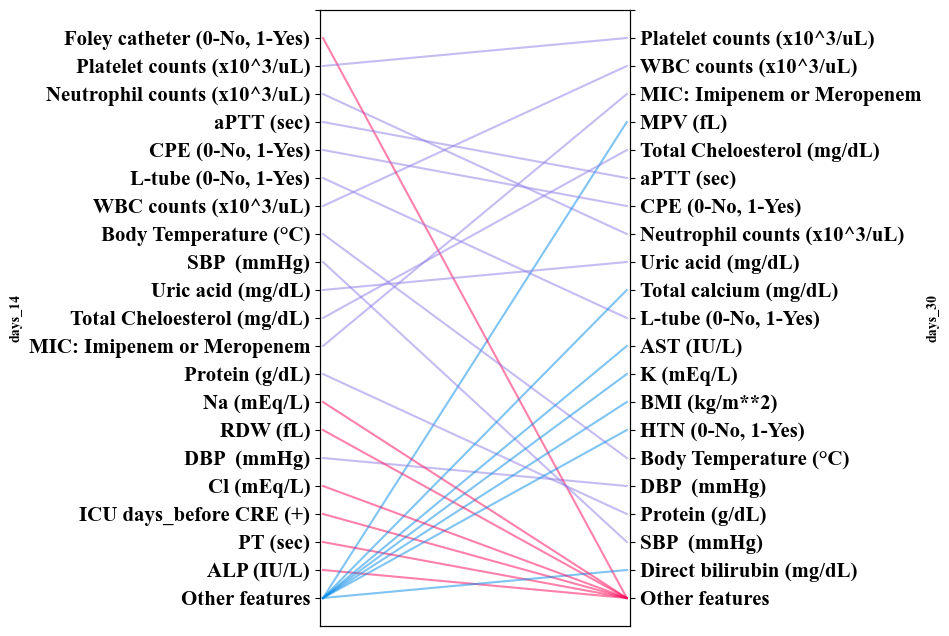

In [12]:
left_model = 'thesis 14'
right_model = 'thesis 2'
X_left = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+left_model+'/fore_data.xlsx')
X_right = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+right_model+'/fore_data.xlsx')
tree_shap_values_left = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+left_model+'/shap_values.npy')
tree_shap_values_right = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+right_model+'/shap_values.npy')
Gabe_plot_part(tree_shap_values_left, X_left.columns, tree_shap_values_right, X_right.columns, 20, 'days_14', 'days_30')

In [ ]:
# 현재 그림을 TIFF 파일로 저장
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/model comparison plot.tiff', format='tiff', dpi=300)

### SHAP summary plot

In [2]:
model_name = 'Thesis 2'

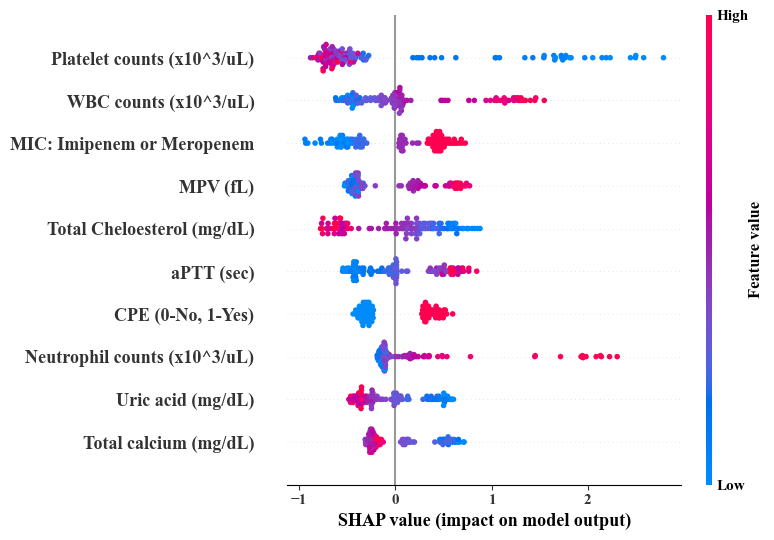

In [6]:
fore_data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')
shap_values = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap_values.npy')
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/feature_list_Display_name thesis 2.xlsx')
display_col = []
for col in fore_data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(fore_data.columns, display_col))

fore_data = fore_data.rename(columns=col_dict)
shap.summary_plot(shap_values, fore_data, max_display=10, show=False)
# 현재 그림을 TIFF 파일로 저장
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap summary plot 10.tiff', format='tiff', dpi=300)
plt.show()

### SHAP values plot

In [11]:
model_name = 'thesis 2'
feature = 'WBC, Low'

<Figure size 640x480 with 0 Axes>

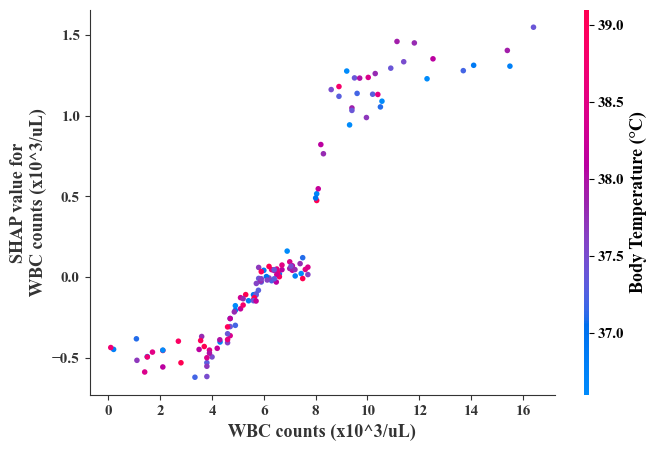

In [12]:
fore_data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')
shap_values = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap_values.npy')
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/feature_list_Display_name thesis 2.xlsx')
display_col = []
for col in fore_data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(fore_data.columns, display_col))

fore_data = fore_data.rename(columns=col_dict)
plt.subplots_adjust(left=0.2, right=0.9)  # left와 right 값을 조정해보세요
shap.dependence_plot(col_dict[feature], shap_values, fore_data, show=False, feature_names=display_col, interaction_index=col_dict['Highest Body Temperature'])
# 현재 그림을 TIFF 파일로 저장
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap values plot-'+feature+'.tiff', format='tiff', dpi=300)
plt.show()

### SHAP main effect plot

In [6]:
model_name = 'thesis 2'
feature = 'Highest Body Temperature'

In [50]:
def model_proba(x):
    return model.predict_proba(x)[:,1]
def model_relative_proba(x):
    return model.predict_proba(x)[:,1]/expected_proba
def model_logodds(x):
    return model.predict(x, output_margin=True)
def model_odds(x):
    return np.exp(model.predict(x, output_margin=True))
def logodds_proba(x):
    return np.exp(x)/(1+np.exp(x))
def proba_logodds(x):
    return np.log(x/(1-x))
def odds_proba(x):
    return x/(1+x)
def logodds_odds(x):
    return np.exp(x)
def odds_logodds(x):
    return np.log(x)

# RI 정보가 저장된 Excel 파일 경로
ri_excel_path = '/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/RI.xlsx'

# Excel 파일로부터 RI 정보를 불러옵니다. 필요한 경우 sheet_name 파라미터를 조정하세요.
ri_df = pd.read_excel(ri_excel_path, sheet_name='Sheet1')

# RI 정보를 딕셔너리 형태로 변환합니다.
# 이 예제에서는 각 행이 하나의 feature를 나타내며, 'Type_Short_Name', 'RI_all' 등의 컬럼을 가정합니다.
RI_dict = ri_df.set_index('Type_Short_Name')['RI_all'].to_dict()

# Correctly extract lower and upper bounds
bounds = RI_dict[feature].split('-')
lower_bound = float(bounds[0])
upper_bound = float(bounds[1])

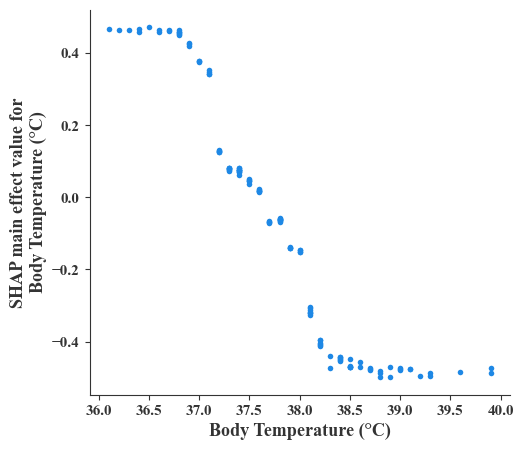

In [7]:
fore_data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')
shap_inter_values = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap_interaction_values.npy')
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/feature_list_Display_name thesis 2.xlsx')
display_col = []
for col in fore_data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(fore_data.columns, display_col))

fore_data = fore_data.rename(columns=col_dict)
shap.dependence_plot((col_dict[feature], col_dict[feature]), shap_inter_values, fore_data, show=False, feature_names=display_col, interaction_index=None)
plt.subplots_adjust(left=0.2, right=0.9)  # left와 right 값을 조정해보세요
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap main effect plot-'+feature+'.tiff', format='tiff', dpi=300)
plt.show()

In [ ]:
plt.axvline(x=lower_bound, color='#78e08f', linestyle='--')
plt.axvline(x=upper_bound, color='#78e08f', linestyle='--')
plt.axvspan(lower_bound, upper_bound, color='#78e08f', alpha=0.2, lw=0)

In [4]:
plt.subplots_adjust(left=0.2, right=0.9)  # left와 right 값을 조정해보세요
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap main effect plot-'+feature+'.tiff', format='tiff', dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

### SHAP interaction plot

In [13]:
model_name = 'thesis 2'
feature = 'WBC, Low'

In [14]:
def model_proba(x):
    return model.predict_proba(x)[:,1]
def model_relative_proba(x):
    return model.predict_proba(x)[:,1]/expected_proba
def model_logodds(x):
    return model.predict(x, output_margin=True)
def model_odds(x):
    return np.exp(model.predict(x, output_margin=True))
def logodds_proba(x):
    return np.exp(x)/(1+np.exp(x))
def proba_logodds(x):
    return np.log(x/(1-x))
def odds_proba(x):
    return x/(1+x)
def logodds_odds(x):
    return np.exp(x)
def odds_logodds(x):
    return np.log(x)

# RI 정보가 저장된 Excel 파일 경로
ri_excel_path = '/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/RI.xlsx'

# Excel 파일로부터 RI 정보를 불러옵니다. 필요한 경우 sheet_name 파라미터를 조정하세요.
ri_df = pd.read_excel(ri_excel_path, sheet_name='Sheet1')

# RI 정보를 딕셔너리 형태로 변환합니다.
# 이 예제에서는 각 행이 하나의 feature를 나타내며, 'Type_Short_Name', 'RI_all' 등의 컬럼을 가정합니다.
RI_dict = ri_df.set_index('Type_Short_Name')['RI_all'].to_dict()

# Correctly extract lower and upper bounds
bounds = RI_dict[feature].split('-')
lower_bound = float(bounds[0])
upper_bound = float(bounds[1])

<Figure size 1000x600 with 0 Axes>

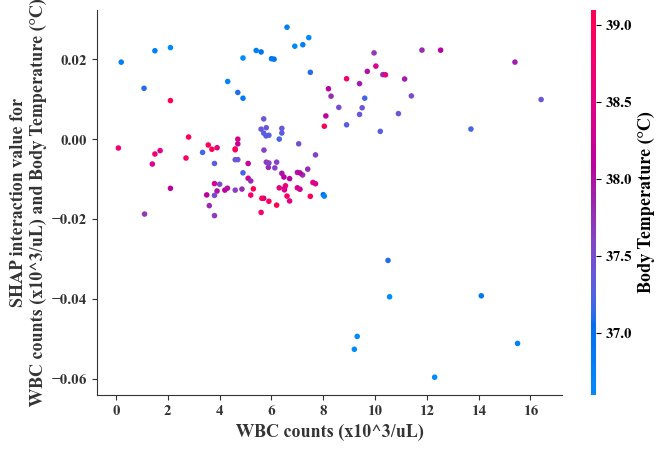

In [15]:
fore_data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')
shap_inter_values = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap_interaction_values.npy')
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/feature_list_Display_name thesis 2.xlsx')
display_col = []
for col in fore_data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(fore_data.columns, display_col))

fore_data = fore_data.rename(columns=col_dict)
plt.figure(figsize=(10, 6)) 
shap.dependence_plot((col_dict[feature], col_dict['Highest Body Temperature']), shap_inter_values, fore_data, feature_names=display_col, show=False)

<Figure size 1000x600 with 0 Axes>

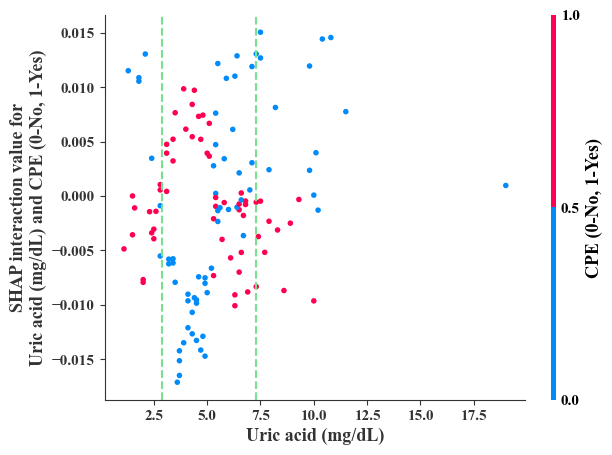

In [22]:
fore_data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')
shap_inter_values = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap_interaction_values.npy')
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/feature_list_Display_name thesis 2.xlsx')
display_col = []
for col in fore_data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(fore_data.columns, display_col))

fore_data = fore_data.rename(columns=col_dict)
plt.figure(figsize=(10, 6)) 
shap.dependence_plot((col_dict[feature], col_dict['CPE_1']), shap_inter_values, fore_data, feature_names=display_col, show=False)

plt.axvline(x=lower_bound, color='#78e08f', linestyle='--')
plt.axvline(x=upper_bound, color='#78e08f', linestyle='--')
plt.subplots_adjust(left=0.2, right=0.9)  # left와 right 값을 조정해보세요
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/SHAP interaction plot-' + feature + '.tiff', format='tiff', dpi=300)
plt.show()

In [17]:
fore_data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')
shap_inter_values = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap_interaction_values.npy')
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/feature_list_Display_name thesis 2.xlsx')
display_col = []
for col in fore_data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(fore_data.columns, display_col))

fore_data = fore_data.rename(columns=col_dict)
plt.figure(figsize=(10, 6)) 
shap.dependence_plot((col_dict[feature], col_dict['CPE_1']), shap_inter_values, fore_data, feature_names=display_col, show=False)
plt.subplots_adjust(left=0.2, right=0.9)  # left와 right 값을 조정해보세요
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/SHAP interaction plot-' + feature + '.tiff', format='tiff', dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

### SHAP individualized plot

In [27]:
model_name = 'CRE_BSI'
idx = 0

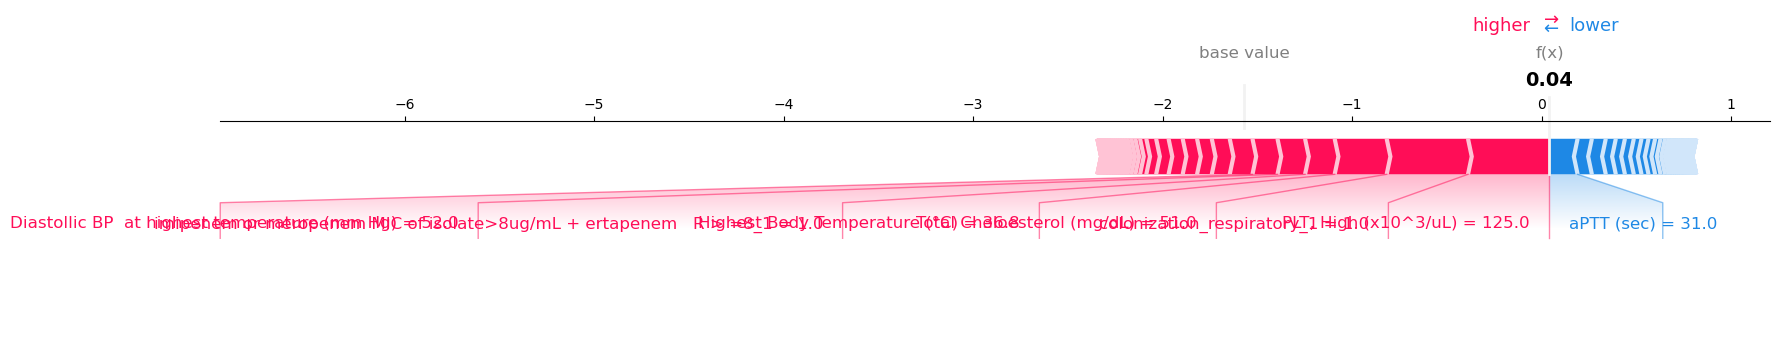

In [29]:
fore_data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')
shap_values = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap_values.npy')
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/feature_list_Display_name.xlsx')
model = pickle.load(open('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/model.pickle.dat', "rb"))
display_col = []
for col in fore_data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(fore_data.columns, display_col))

fore_data = fore_data.rename(columns=col_dict)
explainer = shap.TreeExplainer(model)
shap.force_plot(explainer.expected_value, shap_values[idx,:], fore_data.iloc[idx,:], matplotlib=True, feature_names=display_col, show=True, text_rotation=0)

In [ ]:
# 현재 그림을 TIFF 파일로 저장
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap individualized plot.tiff', format='tiff', dpi=300)